## Import libraries:

In [13]:
from imports import *

# Individual coordinate reconstruction (t,x,y,z)

**hit_nuvT variable loading**

In [14]:
table = pq.read_table('saved_archives/ophit_variables.parquet')
hit_nuvT_f = ak.from_iter(table.column('hit_nuvT_fc').to_pylist())
del table

**Model architecture definition**

In [17]:
def create_cnn_model(x_train, conv_dim, maxpool_dim):

    from tensorflow.keras import layers, models
    from tensorflow.keras.callbacks import ModelCheckpoint
    """
    Creates a CNN model based on the provided architecture.
    
    Parameters:
    - input_shape: tuple, the shape of the input data (excluding batch size).
    
    Returns:
    - model: A compiled CNN model.
    """
    # Input layer
    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
    input_layer = layers.Input(shape=input_shape)
    masking_layer = layers.Masking(mask_value=0)(input_layer)
    
    # First convolutional block
    model = layers.BatchNormalization()(masking_layer)
    model = layers.Conv2D(32, conv_dim, padding='same')(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D(maxpool_dim, padding='same')(model)
    
    # Second convolutional block
    model = layers.Conv2D(64, conv_dim, padding='same')(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    #model = layers.MaxPooling2D(maxpool_dim, padding='same')(model)

    # Third convolutional block
    model = layers.Conv2D(128, conv_dim, padding='same')(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    #model = layers.MaxPooling2D(maxpool_dim, padding='same')(model)

    
    # Flatten the output and pass through dense layers
    model = layers.Flatten()(model)
    model = layers.Dense(256, activation='relu')(model)
    model = layers.Dropout(0.2)(model)
    model = layers.Dense(128, activation='relu')(model)
    model = layers.Dropout(0.2)(model)
    
    # Output layer
    output_layer = layers.Dense(1, activation='linear')(model)
    
    # Create the model
    model_def = models.Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    model_def.compile(loss='mse', optimizer='adam', metrics=['mse'])

    return model_def

## 4-component realistic representation

**Training and set separation**

In [4]:
x_train_realistic_4comp, x_test_realistic_4comp, train_nuvT_realistic_4comp, test_nuvT_realistic_4comp = split_train_test("/data/vidales/images/image_realistic_4comp.npy", hit_nuvT_f, test_ratio=0.20)

model_realistic_4comp = create_cnn_model(x_train_realistic_4comp, (4,5),(2,2))

nuvT_pred_realistic_4comp, history_t_realistic_4comp = train_and_predict(model_realistic_4comp, x_train_realistic_4comp, train_nuvT_realistic_4comp, x_test_realistic_4comp, test_nuvT_realistic_4comp, epochs=30, batch_size=32)

Test size: 5916
x_train shape: (23666, 59, 70, 16), x_test shape: (5916, 59, 70, 16)
train_nuvT length: 23666, test_nuvT length: 5916
Test size: 5916
x_train shape: (23666, 9, 36, 16), x_test shape: (5916, 9, 36, 16)
train_nuvT length: 23666, test_nuvT length: 5916


In [18]:
x_train_compressed_4comp, x_test_compressed_4comp, train_nuvT_compressed_4comp, test_nuvT_compressed_4comp = split_train_test("/data/vidales/images/image_compressed_4comp_1411.npy", hit_nuvT_f, test_ratio=0.20)

Test size: 5916
x_train shape: (23666, 9, 36, 16), x_test shape: (5916, 9, 36, 16)
train_nuvT length: 23666, test_nuvT length: 5916


In [19]:
model_compressed_4comp = create_cnn_model(x_train_compressed_4comp, (4,5),(2,2))

In [20]:
nuvT_pred_compressed_4comp, history_t_compressed_4comp = train_and_predict(model_compressed_4comp, x_train_compressed_4comp, train_nuvT_compressed_4comp, x_test_compressed_4comp, test_nuvT_compressed_4comp, epochs=30, batch_size=32)

Epoch 1/30
740/740 [==============================] - 7s 6ms/step - loss: 66.9536 - mse: 66.9536 - val_loss: 70.9802 - val_mse: 70.9802
Epoch 2/30
740/740 [==============================] - 4s 5ms/step - loss: 65.2378 - mse: 65.2378 - val_loss: 63.6522 - val_mse: 63.6522
Epoch 3/30
740/740 [==============================] - 4s 6ms/step - loss: 64.4783 - mse: 64.4783 - val_loss: 63.3468 - val_mse: 63.3468
Epoch 4/30
740/740 [==============================] - 4s 5ms/step - loss: 64.3705 - mse: 64.3705 - val_loss: 63.5801 - val_mse: 63.5801
Epoch 5/30
740/740 [==============================] - 4s 5ms/step - loss: 64.1537 - mse: 64.1537 - val_loss: 64.2469 - val_mse: 64.2469
Epoch 6/30
740/740 [==============================] - 4s 5ms/step - loss: 64.0575 - mse: 64.0575 - val_loss: 64.5424 - val_mse: 64.5424
Epoch 7/30
740/740 [==============================] - 4s 5ms/step - loss: 64.2068 - mse: 64.2068 - val_loss: 66.9658 - val_mse: 66.9658
Epoch 8/30
740/740 [============================

# Visualización de resultados

**Metrics computed**

In [22]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

testScoreMSE_nuvT = mean_squared_error(test_nuvT_compressed_4comp, nuvT_pred_compressed_4comp)
r2 = r2_score(test_nuvT_compressed_4comp, nuvT_pred_compressed_4comp)
mape = mean_absolute_percentage_error(test_nuvT_compressed_4comp, nuvT_pred_compressed_4comp)

print('RMSE: %.3f' % np.sqrt((testScoreMSE_nuvT)))
print('R²: %.3f' % r2)
print('MAPE: %.2f%%' % mape)

RMSE: 7.959
R²: -0.001
MAPE: 1518.90%


**Evolution of loss over epochs for the training and test set**

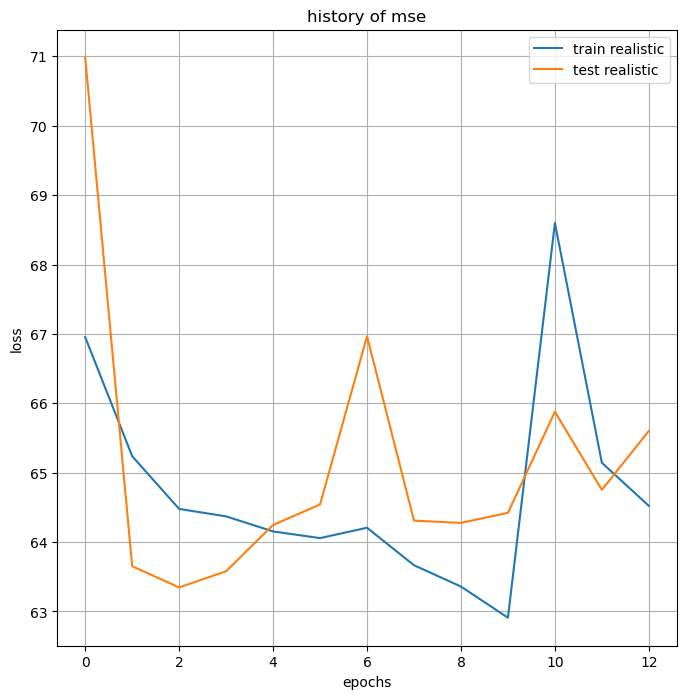

In [24]:
plt.figure(1, figsize=(8,8))
plt.plot(history_t_compressed_4comp.history['mse'])
plt.plot(history_t_compressed_4comp.history['val_mse'])
#plt.plot(history_t_compressed_visvuv.history['mse'])
#plt.plot(history_t_compressed_visvuv.history['val_mse'])

#plt.yscale("log")
plt.title('history of mse')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.grid()
plt.legend(['train realistic', 'test realistic', 'train compressed', 'test compressed'], loc='upper right')
#plt.ylim(10**4,2*10**6)
plt.show()

**Prediction vs real plot**

In [13]:
def plot_predictions_vs_real(test_nuvT, pred_nuvT):
    fig, axs = plt.subplots(1, 2, figsize=(14, 9))
    fig.suptitle("Predicted vs Real")

    # Scatter plot
    axs[0].scatter(test_nuvT, pred_nuvT, color="black", s=5)
    axs[0].grid()
    #axs[0].plot([350, 1800], [350, 1800], color="r")
    axs[0].title.set_text('nuvT')
    #axs[0].set_xlim([-1, 20])
    #axs[0].set_ylim([-1, 20])
    axs[0].set_ylabel('Predicted [ns]')
    axs[0].set_xlabel('Real [ns]')

    # 2D histogram
    im1 = axs[1].hist2d(test_nuvT, pred_nuvT.flatten(), bins=(100, 300), cmap='viridis', cmax=30)
    axs[1].grid()
    #axs[1].plot([-1, 20], [-1, 20], color="r")
    #axs[1].set_xlim([-1, 20])
    #axs[1].set_ylim([-1, 20])
    axs[1].set_ylabel('Predicted [ns]')
    axs[1].set_xlabel('Real [ns]')
    axs[1].set_facecolor('#440154')

    fig.tight_layout()
    
    # Uncomment to save the figure
    # plt.savefig('/tmp/CNNx2+4T+N_Recta_I.png', dpi=300)

    plt.show()

# Example usage
# plot_predictions_vs_real(test_nuvT, nuvT_pred_realistic)


In [ ]:
plot_predictions_vs_real(test_nuvT_realistic_4comp, nuvT_pred_realistic_4comp)

**Gaussian fit of the residuals between prediction and actual data to check the quality of the results**

------------------
Media nuvT = 5.580523491402194
Sigma nuvT = 52.49821478635204
------------------


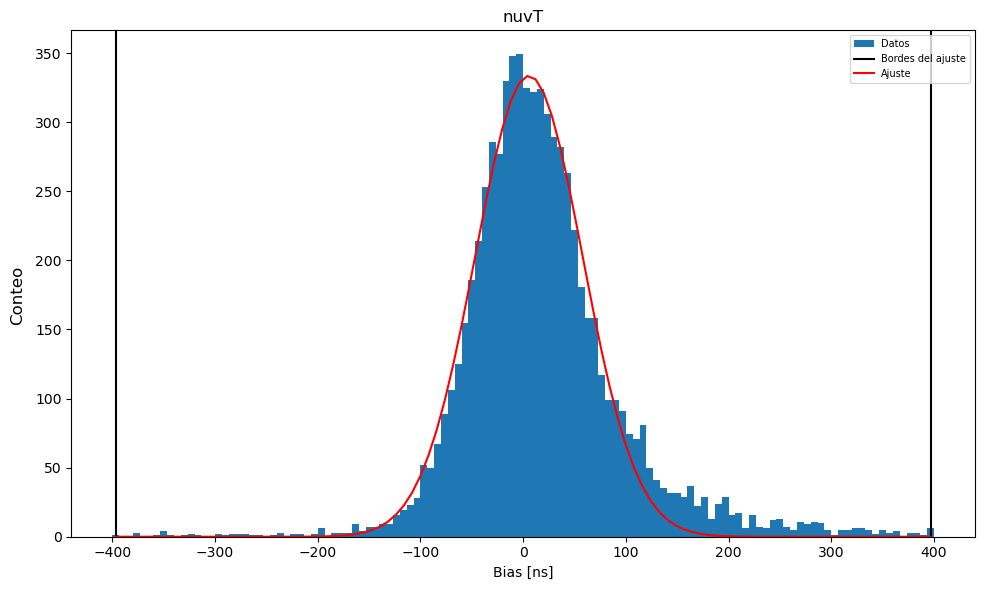

In [16]:
# Gaussian fit of the difference between the prediction and the real value

from scipy.optimize import curve_fit

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# Variables de los histogramas
diff_nuvT = nuvT_pred_realistic.flatten()-test_nuvT

fig, axs = plt.subplots(figsize=(10,6))

# Valores de X
axs.title.set_text('nuvT')
counts_nuvT, bins_nuvT, patches_nuvT = axs.hist(diff_nuvT,120, range=[-400,400], label='Data')

step_nuvT = (bins_nuvT[1]-bins_nuvT[0])/2
bin_centers_nuvT = bins_nuvT[:-1]+step_nuvT

ini_nuvT = 0
fin_nuvT = 119
axs.axvline(x = bin_centers_nuvT[ini_nuvT], color = 'k', label='Edge"s fit')
axs.axvline(x = bin_centers_nuvT[fin_nuvT], color = 'k')

popt_nuvT, pcov_nuvT = curve_fit(func, bin_centers_nuvT[ini_nuvT:fin_nuvT+1], counts_nuvT[ini_nuvT:fin_nuvT+1])


ym_nuvT = func(np.linspace(bin_centers_nuvT[ini_nuvT], bin_centers_nuvT[fin_nuvT],100), popt_nuvT[0], popt_nuvT[1], popt_nuvT[2])
axs.plot(np.linspace(bin_centers_nuvT[ini_nuvT], bin_centers_nuvT[fin_nuvT],100), ym_nuvT, c='r', label='Fit')
axs.set_xlabel('Bias [ns]')
axs.legend(prop = { "size": 7 })

fig.supylabel('Count')
fig.tight_layout()

# plt.savefig('/tmp/CNNx2+4T+N_Distrib_I.png', dpi=300)

print('------------------')
print('Mean nuvT =',popt_nuvT[1])
print('St. Dev. nuvT =',popt_nuvT[2])
print('------------------')


In [17]:
print('Gauss nuvT')
print(np.std(diff_nuvT))
print(np.mean(diff_nuvT))

Gauss nuvT
115.17707820363492
24.574550175010334


## Visualización de las representaciones intermedias

Se visualiza las características intermedias aprendidas por la CNN. Se puede observar como la entrada se transforma al pasar através de las capas. Se selecciona una imagen aleatoria del conjunto de entrenamiento y se visualiza durante su transformación. Cada fila corresponde con una capa y cada imagen en la fila con un filtro.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def visualize_intermediate_layers(model, x_train, sample_index=0):
    """
    Visualizes intermediate layer outputs for a specific sample from the training data.
    
    Parameters:
    - model: The trained Keras model.
    - x_train: The training data.
    - sample_index: Index of the sample from x_train to visualize.
    """
    # Get the outputs of all intermediate layers
    successive_outputs = [layer.output for layer in model.layers[1:]]
    visualization_model = Model(inputs=model.input, outputs=successive_outputs)
    
    # Select a sample image from x_train
    sample_image = x_train[sample_index:sample_index + 1]  # Shape should be (1, height, width, channels)
    
    # Pass the image through the model to get intermediate representations
    successive_feature_maps = visualization_model.predict(sample_image)
    
    # Get layer names for labeling
    layer_names = [layer.name for layer in model.layers[1:]]
    
    # Plot each layer's feature map
    for layer_name, feature_map in zip(layer_names, successive_feature_maps):
        if len(feature_map.shape) == 4:  # Only consider convolutional layers (ignore dense layers)
            n_features = feature_map.shape[-1]  # Number of filters
            size = feature_map.shape[1]  # Spatial dimensions
            
            # Create a grid for visualizing each filter's feature map
            display_grid = np.zeros((size, size * n_features))
            
            for i in range(n_features):
                x = feature_map[0, :, :, i]
                
                # Normalize the feature map values for better visualization
                x -= x.mean()
                x /= (x.std() + 1e-5)
                x *= 64
                x += 128
                x = np.clip(x, 0, 255).astype('uint8')
                
                # Resize or pad `x` if it doesn't match the expected dimensions
                if x.shape[1] < size:
                    x = np.pad(x, ((0, 0), (0, size - x.shape[1])), mode='constant')
                elif x.shape[1] > size:
                    x = x[:, :size]
                
                # Put each filter's activation in the display grid
                display_grid[:, i * size : (i + 1) * size] = x
            
            # Display the grid
            scale = 20. / n_features
            plt.figure(figsize=(scale * n_features, scale))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')
            plt.show()

# Use the function to visualize intermediate representations of your model
# Assuming x_train is your training data and create_cnn_model has been defined
#model, _ = create_cnn_model(x_train, conv_dim=(3, 3), maxpool_dim=(2, 2))
#visualize_intermediate_layers(model, x_train)


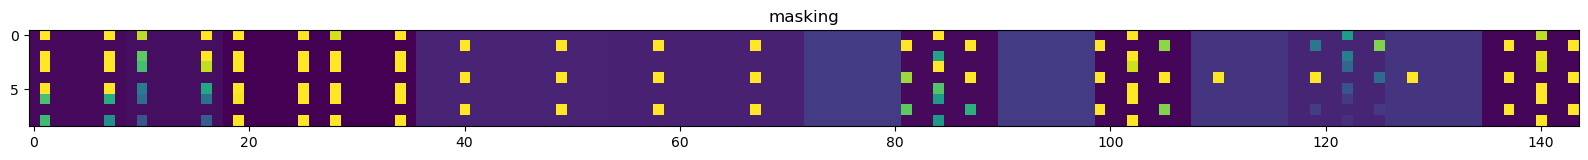

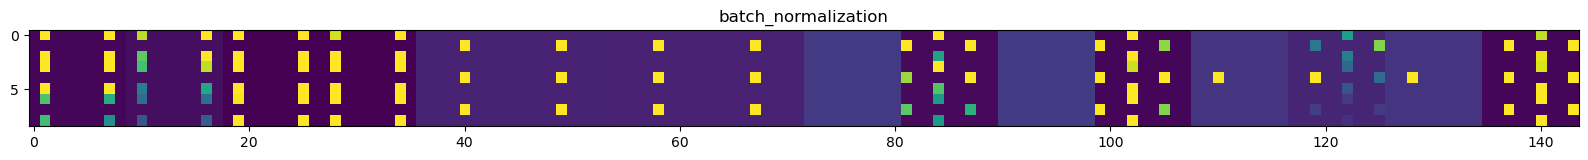

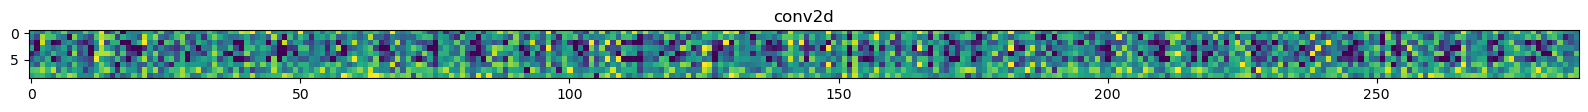

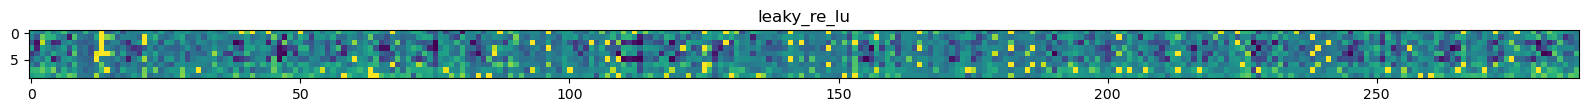

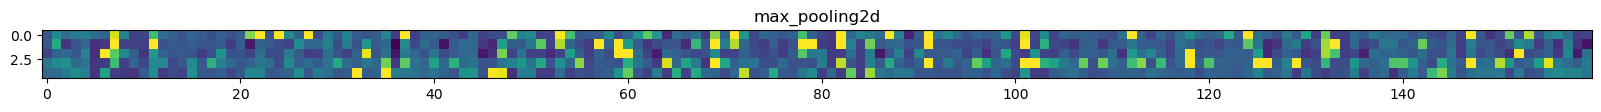

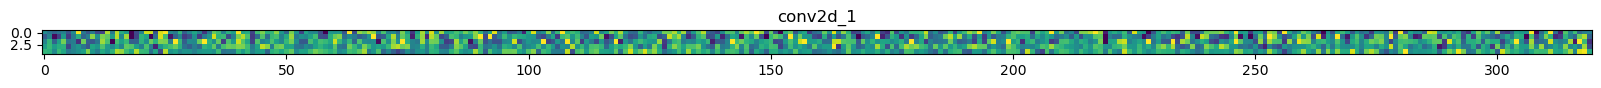

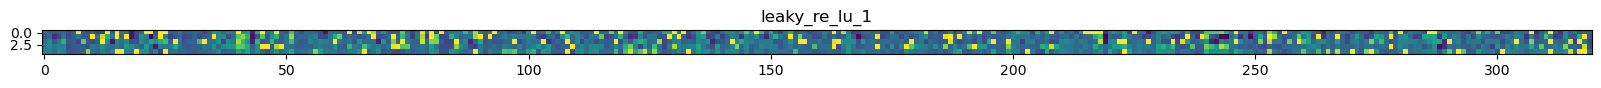

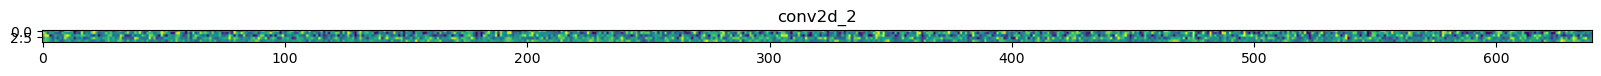

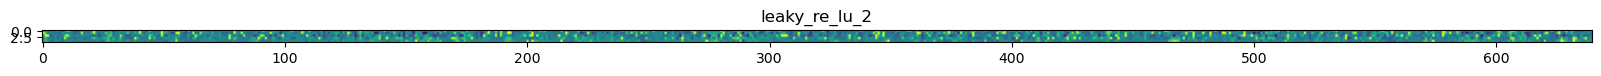

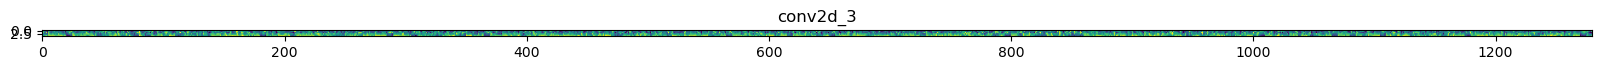

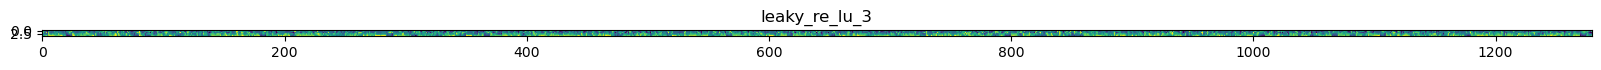

In [ ]:
visualize_intermediate_layers(model_compressed_4comp, x_train_compressed_4comp, sample_index=3)